In [3]:
import tensorflow as tf, os, json
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import backend as K
import os, json
from keras.callbacks import  EarlyStopping, LearningRateScheduler,ModelCheckpoint
from keras.layers import Dense, Flatten,Dropout
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,roc_curve, roc_auc_score,auc
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU')
from keras.models import load_model, Model

Optimizing Memory

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # use the first GPU

from keras import backend as K

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config))

In [ ]:
train_dir = r'D:\College\Fourth Year\Grad Project\Code\sp2\train'
val_dir = r'D:\College\Fourth Year\Grad Project\Code\sp2\val'
test_dir = r'D:\College\Fourth Year\Grad Project\Code\sp2\test'

ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

In [4]:
base_model = VGG19(weights=r'D:\College\Fourth Year\Grad Project\Code\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model and top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           mode='auto')
def lr_scheduler(epoch):
    lr = 1e-4
    if epoch > 20:
        lr *= 0.1 
    return lr
lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1,
                             save_best_only=True)


Model Training

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.n//val_generator.batch_size,
    callbacks=[early_stop, lr_schedule,checkpoint])

In [ ]:
model.save('VGG19##.h5')

Model Statistics

Val Accuracy:  0.8519531488418579
Train Accuracy:  0.8793839812278748


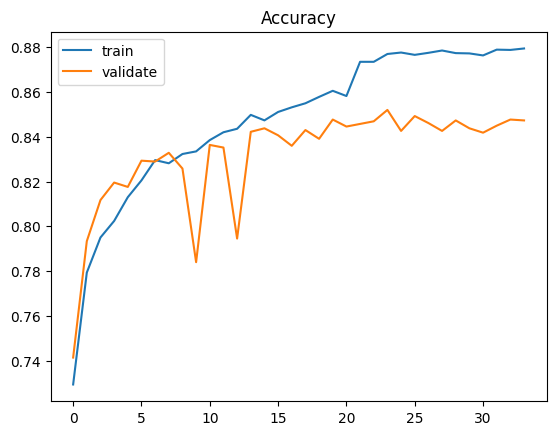

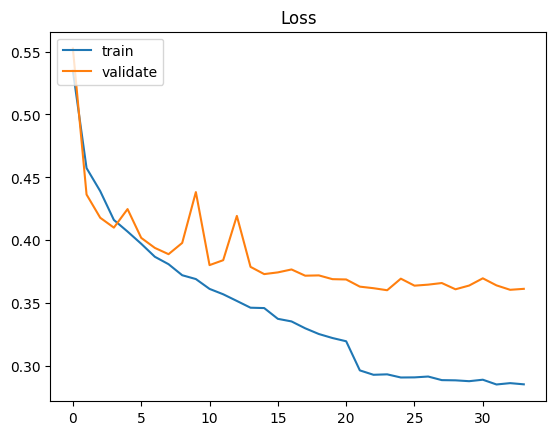

In [5]:
# history.history = {k: [float(i) for i in v] for k, v in history.history.items()}
# with open('history.json', 'w') as f:
#     json.dump(history.history, f)

with open(r'D:\College\Fourth Year\Grad Project\Code\88% VGG19\history.json') as f:
    history = json.load(f)
val_acc = history['val_accuracy']
acc=history['accuracy']
print("Val Accuracy: ",max(val_acc))
print("Train Accuracy: ",max(acc))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['train', 'validate'], loc='upper left')
plt.title("Accuracy")
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['train', 'validate'], loc='upper left')
plt.title("Loss")
plt.show()

In [ ]:
model=load_model(r'D:\College\Fourth Year\Grad Project\Code\88% VGG19\VGG19.h5')
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_generator.reset()
preds = model.predict(test_generator, verbose=1)

y_true = test_generator.classes
y_pred = preds > 0.5  # Convert probabilities to binary predictions

print('Classification Report:')
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
# print('Confusion Matrix:')
# print(confusion_matrix(y_true, y_pred))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1_score)

test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

# Calculate ROC-AUC score
auc_score = roc_auc_score(y_true, preds)
print('ROC-AUC Score:', auc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, preds)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

y_score = y_pred.ravel() if y_pred.ndim == 2 else y_pred
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()